In [661]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
% matplotlib inline
from descartes import PolygonPatch

### crime data

In [2]:
r = requests.get('http://www.criminaljustice.ny.gov/crimnet/ojsa/indexcrimes/county_totals.htm')

In [8]:
soup = BeautifulSoup(r.text)


In [36]:
# get all the links
links = [ str(tag.get('href')) for tag in soup.table.find_all('a') if re.search(r'xls',str(tag))  ]

In [41]:
urlbase = 'http://www.criminaljustice.ny.gov/crimnet/ojsa/indexcrimes/'
s = requests.Session()
for tag in links:
    print tag
    rx = s.get(urlbase+str(tag))
    with open (tag,'w') as outfile:
        outfile.write(rx.content)
        

Albany.xls
Franklin.xls
Oneida.xls
Schuyler.xls
Allegany.xls
Fulton.xls
Onondaga.xls
Seneca.xls
Bronx.xls
Genesee.xls
Ontario.xls
Steuben.xls
Broome.xls
Greene.xls
Orange.xls
Suffolk.xls
Cattaraugus.xls
Hamilton.xls
Orleans.xls
Sullivan.xls
Cayuga.xls
Herkimer.xls
Oswego.xls
Tioga.xls
Chautauqua.xls
Jefferson.xls
Otsego.xls
Tompkins.xls
Chemung.xls
Kings.xls
Putnam.xls
Ulster.xls
Chenango.xls
Lewis.xls
Queens.xls
Warren.xls
Clinton.xls
Livingston.xls
Rensselaer.xls
Washington.xls
Columbia.xls
Madison.xls
Richmond.xls
Wayne.xls
Cortland.xls
Monroe.xls
Rockland.xls
Westchester.xls
Delaware.xls
Montgomery.xls
StLawrence.xls
Wyoming.xls
Dutchess.xls
Nassau.xls
Saratoga.xls
Yates.xls
Erie.xls
NewYork.xls
Schenectady.xls
Essex.xls
Niagara.xls
Schoharie.xls
County-totals.xls


In [423]:
c_read=pd.read_excel('./data_CrimeNYS/Albany.xls',skiprows=7)


### shapefile : elementary,secondary and unified school districts from census

In [1032]:
#shapefile : census school district (note: NYC is considered one big bloc)

unsd_read = gpd.read_file('./Shapefiles/tl_2015_36_unsd.shp')
#elsd_read = gpd.read_file('./Shapefiles/tl_2015_36_elsd.shp')
scsd_read = gpd.read_file('./Shapefiles/tl_2015_36_scsd.shp')

In [845]:
# 
sc_toAdd = scsd_read[scsd_read['NAME'].str.contains('Bellmore-Merrick|Sewanhaka|Valley Stream')][['NAME','GEOID','geometry']]
#el_toAdd = elsd_read[elsd_read['NAME'].str.contains('Franklin Square')][['NAME','GEOID','geometry']]
nysch = unsd_read[['NAME','GEOID','geometry']].append(sc_toAdd)
#nysch = nysch.append(el_toAdd)

# delete some data
#nysch=nysch[~nysch["NAME"].str.contains('School District Not Defined')]
#nysch=nysch[~nysch["NAME"].str.contains('Binghamton Common School District')]

nysch['newIndex'] = range(len(nysch))
nysch.set_index(['newIndex'],inplace=True)

In [823]:
# for initial matching to NYS school performance data
nysch['NAME'].to_csv('./NYSED_3-8gradeAssess_2014-2015/sdNames.census_shx.csv')

In [1164]:
nysch[0:3]

,NAME,GEOID,geometry
newIndex,,,
0,North Shore Central School District,3626370,"POLYGON ((-73.67107299999999 40.859299, -73.65..."
1,Seaford Union Free School District,3626400,"POLYGON ((-73.50683099999999 40.666806, -73.50..."
2,Uniondale Union Free School District,3629280,"POLYGON ((-73.619737 40.68251799999999, -73.61..."


### Set the reference geometry that everything will be overlayed on.
#### currently using school geometry  (can be other shapes)

In [1038]:
# use school geometry as the reference (can be other shapes)
df_refSHP=nysch
refSHP=df_refSHP['geometry'].tolist()

### school performance data (with shapefile index assigned by addSchDistrict.pl)

In [1005]:
performance=pd.read_table('./NYSED_3-8gradeAssess_2014-2015/3-8_ELA_AND_MATH_RESEARCHER_FILE_2015.DISTRICTSwSHPassignment.tab')
performance['SID']=performance['SID'].astype(int)
performance['MEAN_SCALE_SCORE']=pd.to_numeric(performance['MEAN_SCALE_SCORE'],errors=coerce)
performance['L4_PCT']=pd.to_numeric(performance['L4_PCT'],errors=coerce)


In [995]:
performance.columns

Index([u'SID', u'SCHOOL_YEAR', u'NRC_CODE', u'NRC_DESC', u'COUNTY_CODE',
       u'COUNTY_DESC', u'BEDSCODE', u'SD_NAME', u'ITEM_SUBJECT_AREA',
       u'ITEM_DESC', u'SUBGROUP_CODE', u'SUBGROUP_NAME', u'TOTAL_TESTED',
       u'L1_COUNT', u'L1_PCT', u'L2_COUNT', u'L2_PCT', u'L3_COUNT', u'L3_PCT',
       u'L4_COUNT', u'L4_PCT', u'L2-L4_PCT', u'L3-L4_PCT', u'MEAN_SCALE_SCORE',
       u'Sum_Of_SCALE_SCORE'],
      dtype='object')

In [1007]:
# choose here the school metric
schoolScore=performance[['SID','SD_NAME','L4_PCT']][performance['ITEM_DESC'].str.contains('Grade 8 Math')]
schoolScore.rename(columns={'L4_PCT':'SCORE'}, inplace=True)
schoolScore=schoolScore.groupby('SID').mean()
schoolScore[:3]

,SCORE
SID,
0,0
1,10
2,0


N=1151 factor=2


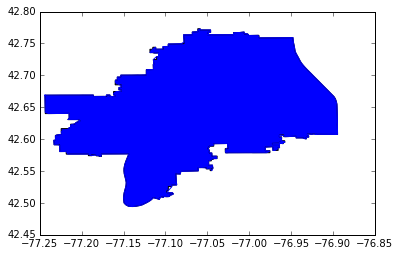

In [769]:
# matplotlib only works up to 999 points -> skip points if >999
def plotGeometry(shape):
    fig=plt.figure()
    ax = fig.add_subplot(111)
    x,y = shape.exterior.xy 
    coords = shape.exterior.coords
    N=len(x)
    factor = N//1000 +1
    shapepatch = PolygonPatch(shape)
    ax.plot(x[::factor],y[::factor]) 
    ax.add_patch(shapepatch)
plotGeometry(schoolScore.at[8259,'geometry'])

In [1138]:
# matplotlib
# matplotlib only works up to 999 points -> skip points if >999
def plotGeometries(shapelist):
    fig=plt.figure()
    ax = fig.add_subplot(111)
    for shape in shapelist:
        x,y = shape.exterior.xy 
        N=len(x)
        factor = N//1000 +1
        #shapepatch = PolygonPatch(shape)
        ax.plot(x[::factor],y[::factor], color='black') 
        #ax.add_patch(shapepatch)

In [1159]:
# bokeh
from bokeh.plotting import show,figure,output_file
from bokeh.io import output_notebook
#output_notebook()


In [1154]:
import shapely
for shape in refSHP:
    if not isinstance(shape,shapely.geometry.polygon.Polygon):
        print type(shape)
        

<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.multipolygon.MultiPol

In [1163]:
def plotGeometries_bk(shapelist):
    output_file("lines.html", title="shapefile plot example")
    p = figure(title="New York State Locales (by school districts)", x_axis_label='longitude', y_axis_label='latitude')    
    for shape in shapelist:
        
        if isinstance(shape,shapely.geometry.polygon.Polygon):
            x,y = shape.exterior.xy 
            N=len(x)
            factor = N//2000 +1
            p.line(x[::factor],y[::factor],color='black')
    show(p)
plotGeometries_bk(refSHP)

### shapefile : zipcodes from census

In [157]:
zc_read=gpd.read_file('./Shapefiles/tl_2015_us_zcta510.shp')


In [168]:
zc_read['ZCTA5CE10']=zc_read['ZCTA5CE10'].astype(int)


In [181]:
# new york zipcode ranges from https://data.ny.gov
nyzc=county[ ((county['ZCTA5CE10'] <=14925) & (county['ZCTA5CE10'] >= 10000)) | (county['ZCTA5CE10'] == 501) | (county['ZCTA5CE10'] == 544)| (county['ZCTA5CE10'] == 6390)][['GEOID10','ZCTA5CE10','geometry']]

In [200]:
sz=nyzc[nyzc['ZCTA5CE10']==10583]


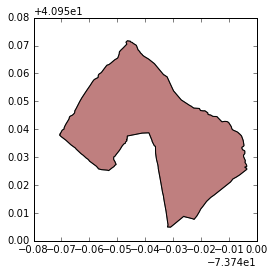

In [570]:
ss.plot()


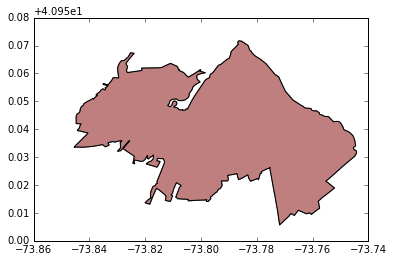

In [427]:
sz.plot()


In [230]:
from geopandas.tools import overlay

ImportError: No module named tools

###   home value per zillow 

In [238]:
zillow_read=pd.read_csv('./Zillow/City_Zhvi_SingleFamilyResidence.csv')


In [421]:
zillow_city_ny=zillow_read[zillow_read['State'].str.contains('NY')]


In [276]:
regionids_nyC=zillow_city_ny['RegionID'].tolist()


In [293]:
zillow_nycity[zillow_nycity['RegionName'].str.contains('Scarsdale')]


,RegionID,RegionName,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01
2424,54333,Scarsdale,NY,New York,Westchester,2425,NaN,NaN,NaN,NaN,...,1397900,1405100,1405700,1412100,1425600,1440700,1456200,1467800,1463100,1452200


### use zillow API to get longitude,latitude by regionid

In [737]:
def z_getRegionChildren (session,regionID,df,myzillowid):

    payload = {'zws-id':myzillowid,'regionId':regionID}
    r = session.get(zillow_api_url,params=payload)
    soup=BeautifulSoup(r.text)
    main_latitude = float(soup.latitude.string)
    main_longitude = float(soup.longitude.string)
    nSubregions = int (soup.list.count.text)
    data=[]
    if nSubregions > 0:
        sub_regiontype=soup.subregiontype.string
        for sub_region in soup.list.find_all('region'):
            sub_region_id = int(sub_region.id.string)
            sub_name = sub_region.find('name').string
            sub_latitude = float(sub_region.latitude.string)
            sub_longitude = float(sub_region.longitude.string)
            if not sub_region.zindex:
                sub_price = main_price
            else: 
                sub_price = int(sub_region.zindex.string)
            data.append( (regionID,sub_regiontype,sub_region_id,sub_name,sub_latitude,sub_longitude,sub_price))
    else:
        data.append( (regionID,'main',regionID,main_name,main_latitude,main_longitude,main_price))
    return data

In [738]:
zillow_api_url='http://www.zillow.com/webservice/GetRegionChildren.htm'
s = requests.Session()
n=0
zillow_ny_regionData = [];
for regionID in regionids_nyC: 
    main_name = zillow_nycity[zillow_nycity['RegionID']==regionID].iat[0,1]
    main_price = zillow_nycity[zillow_nycity['RegionID']==regionID].iat[0,-1]
    datatuple =  z_getRegionChildren (s,regionID,zillow_nycity,myzillowid)
    zillow_ny_regionData.extend(datatuple)
    if (n%20==0):
        print n
    n+=1
    
# save data as file
with open ('../OUTDATA/zillow_ny_regionData.csv','w') as file:
    file.write("ZIDM,ZTYPE,ZIDS,ZNAMES,ZLAT,ZLONG,ZPRICE\n")
    for line in zillow_ny_regionData:
        file.write( "%d,%s,%d,%s,%f,%f,%9.1f\n" %line)



0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940


### merge price and school shapefile

In [739]:
df_zillow_ny_regionData=pd.read_csv('../OUTDATA/zillow_ny_regionData.csv')

In [883]:
#df_zillow_ny_regionData[df_zillow_ny_regionData['ZIDM']==6181] == new york city

In [802]:
# given a point and a list of shapes, find which shape(s) the
# point is in
def findEncompassingShape(point,shapelist):
    assignedList=[]
    for i,refshape in enumerate(shapelist):
        if refshape.contains(p):
            assignedList.append(i)
    return assignedList

# (1:1) assignment of each zillow region to school districts

z=zip(* (df_zillow_ny_regionData['ZLONG'].tolist(),df_zillow_ny_regionData['ZLAT'].tolist()))

assign_zRegion2RefSHP=[]
for i in range(len(z)): 
    p = Point(z[i])
    assignedList = findEncompassingShape(p,refSHP)
    if len(assignedList) > 1:
        print "index %d has %d assignments" %(i,len(assignedList))
        print " ".join(str(x) for x in assignedList)
    else:
        assign_zRegion2RefSHP.append(assignedList[0])
        

In [873]:
df_zillow_ny_regionData['refSHPindex']=assign_zRegion2RefSHP
df_zillow_ny_regionData[:3]

,ZIDM,ZTYPE,ZIDS,ZNAMES,ZLAT,ZLONG,ZPRICE,refSHPindex
0,6181,zipcode,62080,11368,40.752140,-73.853418,413100,299
1,6181,zipcode,62037,11226,40.647434,-73.958823,633400,299
2,6181,zipcode,62093,11385,40.698381,-73.887452,487800,299


### join pricing data with feature(s)

In [1008]:
df_price_features=pd.merge(df_zillow_ny_regionData,schoolScore,left_on='refSHPindex',right_index=True,how='inner')
df_price_features=df_price_features.groupby('refSHPindex').mean()

In [1084]:
df_price_features[df_price_features['ZPRICE']>2500000]

,ZIDM,ZIDS,ZLAT,ZLONG,ZPRICE,SCORE
refSHPindex,,,,,,
662,7774,62321,40.931129,-72.336025,2632400,0


In [913]:
import numpy as np
import re
import math
from sklearn import linear_model as lm
from sklearn.metrics import r2_score

In [915]:
# normalization
def norm(x_in,x_norm):
    
    x_mu = np.mean(x_in)
    x_range = np.amax(x_in) - np.amin(x_in)
    x_norm [:] = [ ( x - x_mu ) / float (x_range) for x in x_in]
    return (x_mu, x_range)

# convert back to abs value
def unnorm(x_mu, x_range, x_norm):
    x_out=[]
    x_out [:] = [ x*x_range+x_mu for x in x_norm ]
    return x_out

In [1010]:
# extract data from dataframes
tmp=df_price_features[['SCORE','ZPRICE']].dropna()
feature1=tmp['SCORE'].tolist()
homevalue=tmp['ZPRICE'].tolist()

In [1011]:
# univariate regression (homePrice vs. SAT score)
x1_norm=[]; y_norm=[]
(x1_mu,x1_range) = norm(feature1,x1_norm)
(y_mu, y_range) = norm(homevalue, y_norm)

# univariate linear regression, with x0=1
#X_train = zip( np.ones(len(x1_norm)),x1_norm)

X_train = np.asarray(zip( np.ones(len(x1_norm)),x1_norm))
#X_train = zip(np.asarray(x1_norm).reshape(-1,1)



In [1012]:
# Create linear regression object
regr = lm.LinearRegression()
regr.fit(X_train, y_norm)

# convert y back to abs value
y_predicted_norm1 = regr.predict(X_train)
y_predicted1 = unnorm(y_mu,y_range,y_predicted_norm1)

print r2_score(y_norm, y_predicted_norm1)


0.0921266199088


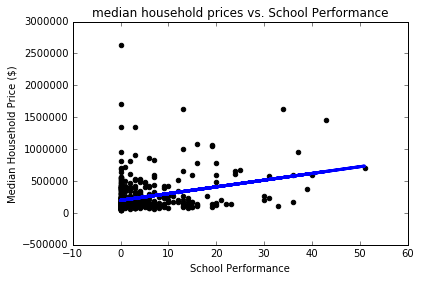

In [1014]:
plt.scatter(feature1,homevalue, color='black')

plt.plot(feature1[::1], y_predicted1[::1], color='blue', linewidth=3)

plt.title("median household prices vs. School Performance")
plt.ylabel("Median Household Price ($)")
plt.xlabel("School Performance")


plt.show()

# posting to postgresql

In [1104]:
from sqlalchemy import create_engine

In [1088]:
local_engine = create_engine('postgresql://enghuiy:@localhost:5432/nysRealEstate')


In [1111]:
# remote db (heroku-app: homevalue-hunter)

remote_engine = create_engine('postgresql://%s:%s@%s:5432/%s' %(USER,PGPASSWORD,HOST,DATABASE))
try:
    connection=remote_engine.connect()
except:
    print "I am unable to connect to the database"

#result = connection.execute("select * from price2features" )

I am unable to connect to the database


In [1058]:
df_price_features.to_sql('price2features', local_engine, if_exists='replace',index_label='refSHPindex')

In [1126]:
df_refSHP[['NAME']].to_sql('refshape', local_engine, if_exists='replace',index_label='refSHPindex')

In [1028]:
df_price_features.to_csv('../OUTDATA/price2features.csv')


# extracting from postgresql

In [1094]:
import psycopg2


In [1109]:
try:
    connl = psycopg2.connect("dbname='nysRealEstate' user='enghuiy' host='localhost' password=''")
except:
    print "I am unable to connect to the database"

In [1114]:
try:

except:
    print "I am unable to connect to the database"

I am unable to connect to the database


In [1123]:
import urlparse
url = urlparse.urlparse(url_)

conn = psycopg2.connect(
    database=url.path[1:],
    user=url.username,
    password=url.password,
    host=url.hostname,
    port=url.port,
#    sslmode='require'
)

OperationalError: FATAL:  no pg_hba.conf entry for host "69.127.188.77", user "ofnhsnebpcurpl", database "daaricgfqmsolv", SSL off


In [1116]:
cur = conn.cursor()
#command=SELECT 'ZPRICE' from price2features
#cur.execute("""SELECT version()""")
#cur.fetchone()

cur.execute("""SELECT "ZPRICE","SCORE" from price2features WHERE "SCORE" IS NOT NULL""")
data=zip(*cur.fetchall())
homevalue = list(data[0])
features  = list(data[1])

NameError: name 'connr' is not defined

In [1130]:
# normalization
def norm(x_in,x_norm):
    
    x_mu = np.mean(x_in)
    x_range = np.amax(x_in) - np.amin(x_in)
    x_norm [:] = [ ( x - x_mu ) / float (x_range) for x in x_in]
    return (x_mu, x_range)

# convert back to abs value
def unnorm(x_mu, x_range, x_norm):
    x_out=[]
    x_out [:] = [ x*x_range+x_mu for x in x_norm ]
    return x_out

# univariate regression
def linearRegression(features,homevalue):
    x_norm=[]; y_norm=[]
    (x_mu,x_range) = norm(features,x_norm)
    (y_mu, y_range) = norm(homevalue, y_norm)

    X_train = np.asarray(zip( np.ones(len(x_norm)),x_norm))

    # Create linear regression object
    regr = lm.LinearRegression()
    regr.fit(X_train, y_norm)
    # convert y back to abs value
    y_predicted_norm = regr.predict(X_train)
    coeffs = regr.coef_
    intercepts = regr.intercept_

    y_predicted = unnorm(y_mu,y_range,y_predicted_norm)

    r2=r2_score(y_norm, y_predicted_norm)
     
    return (coeffs,intercepts,r2,y_predicted)


In [1131]:
coeffs,intercepts,r2,ypredicted =  linearRegression(features,homevalue)
